In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Run this cell only if using Google colab
from google.colab import drive
drive.mount('/content/drive')

import os

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'Histopathology')
print(os.listdir(GOOGLE_DRIVE_PATH))

import sys
sys.path.append(GOOGLE_DRIVE_PATH)

Mounted at /content/drive
['MD5SUMs.txt', 'annotations.csv', 'Dataset Research Use Agreement.pdf', '.DS_Store', 'images', '__pycache__', '.ipynb_checkpoints', 'eda.py', 'eval.py', 'train.py', 'train_images.pkl', 'train_labels.pkl', 'Histo.ipynb']


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [9]:
csv_path = "/content/drive/MyDrive/Histopathology/annotations.csv"
image_folder = "/content/drive/MyDrive/Histopathology/images"

# Read annotations CSV
annotations_df = pd.read_csv(csv_path)

# Split data into train and test sets based on 'Partition' column
train_df = annotations_df[annotations_df['Partition'] == 'train']
test_df = annotations_df[annotations_df['Partition'] == 'test']

# Load train images
train_images = []
train_labels = []

for index, row in train_df.iterrows():
    image_name = row['Image Name']
    image_path = os.path.join(image_folder, image_name)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))

    image_tensor = torch.from_numpy(image).permute(2, 0, 1).float().to(device) / 255.0
    train_images.append(image_tensor)
    train_labels.append(row['Majority Vote Label'])

# Encode train labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)

# Load test images
test_images = []
test_labels = []

for index, row in test_df.iterrows():
    image_name = row['Image Name']
    image_path = os.path.join(image_folder, image_name)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))

    image_tensor = torch.from_numpy(image).permute(2, 0, 1).float().to(device) / 255.0
    test_images.append(image_tensor)
    test_labels.append(row['Majority Vote Label'])

# Encode test labels
test_labels = label_encoder.transform(test_labels)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

In [10]:
os.chdir('/content/drive/MyDrive/Histopathology')

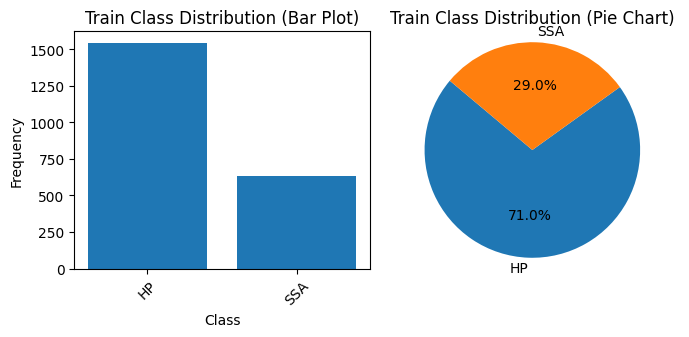

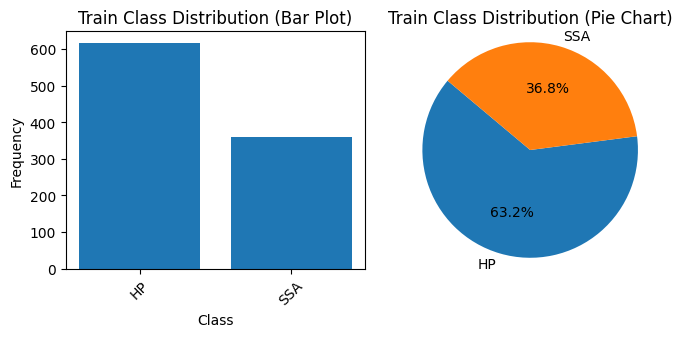

In [12]:
from eda import visualize_class_distribution

# Visualize class distribution for train and test sets
train_class_counts = train_df['Majority Vote Label'].value_counts()
test_class_counts = test_df['Majority Vote Label'].value_counts()

visualize_class_distribution(train_class_counts)
visualize_class_distribution(test_class_counts)

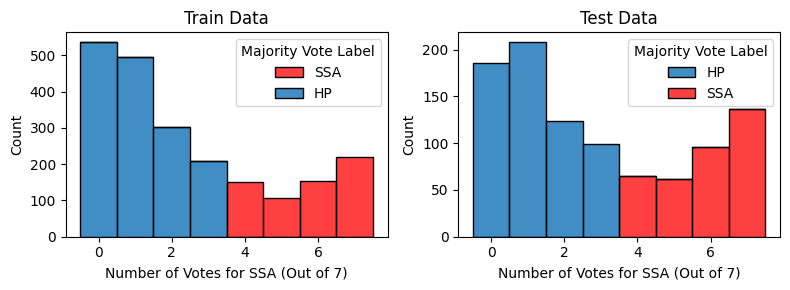

In [81]:
from eda import plot_vote_distribution
plot_vote_distribution(train_df, test_df)

In [13]:
save_train_images = train_images
save_train_labels_tensor = train_labels_tensor

# Upsampling minority class

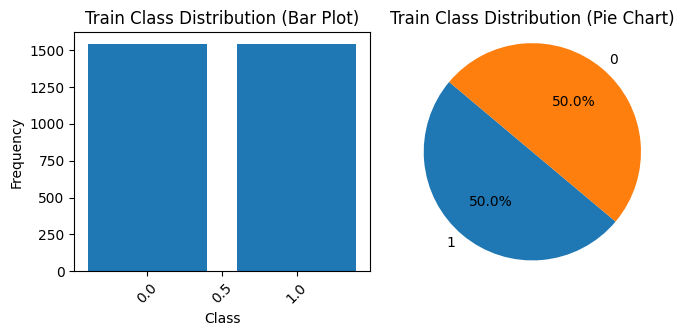

In [14]:
from eda import upsample_minority_class

minority_class_label = 1
upsampled_train_images, upsampled_train_labels = upsample_minority_class(train_images, train_labels_tensor, train_labels,  minority_class_label, device)

# Visualize class distribution for the upsampled train set
train_class_counts = pd.Series(upsampled_train_labels.cpu().numpy()).value_counts()
visualize_class_distribution(train_class_counts)

# Applying CLAHE to enhance features

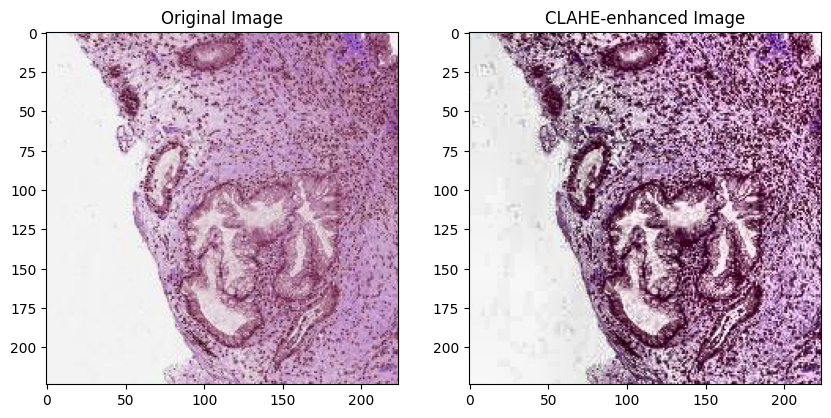

In [92]:
from eda import clahe

train_image_clahe = clahe(train_images[0])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(train_images[0].cpu().permute(1, 2, 0))
axes[0].set_title('Original Image')
axes[1].imshow(train_image_clahe.permute(1, 2, 0))
axes[1].set_title('CLAHE-enhanced Image')
plt.show()

In [15]:
from torch.utils.data import DataLoader, TensorDataset

train_images = upsampled_train_images
train_labels_tensor =  upsampled_train_labels

batch_size = 32

# Train Loader
train_images_tensor = torch.stack(train_images)
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#Test Loader
test_images_tensor = torch.stack(test_images)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = test_loader

# Train Resnet-18

In [71]:
from train import train_cnn
import torchvision.models as models

epochs = 5
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Binary classification, so output size is 2
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_cnn(model, train_loader, val_loader, criterion, optimizer, device, epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


Epoch [1/5], Loss: 0.4382368608848336, Train Accuracy: 0.7815533980582524, Validation Accuracy: 0.7482088024564995
Epoch [2/5], Loss: 0.23020437275318756, Train Accuracy: 0.9055016181229774, Validation Accuracy: 0.8014329580348004
Epoch [3/5], Loss: 0.10609070046507206, Train Accuracy: 0.9637540453074434, Validation Accuracy: 0.8085977482088025
Epoch [4/5], Loss: 0.05164024402800294, Train Accuracy: 0.987378640776699, Validation Accuracy: 0.7911975435005117
Epoch [5/5], Loss: 0.021960893636281342, Train Accuracy: 0.9980582524271845, Validation Accuracy: 0.8167860798362334


Accuracy: 0.8167860798362334
Precision: 0.7387862796833773
Recall: 0.7777777777777778
AUC: 0.8910003601656763


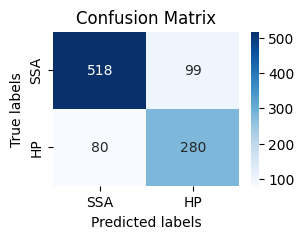

In [72]:
from eval import evaluate_cnn_model, calculate_metrics

test_labels, test_probabilities, test_predictions = evaluate_cnn_model(model, test_loader, criterion, device)
auc = calculate_metrics(test_labels, test_probabilities, test_predictions)

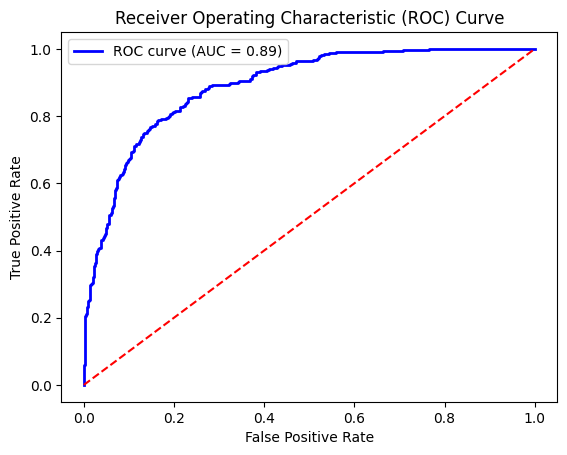

In [73]:
from sklearn.metrics import roc_curve
# ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_probabilities)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

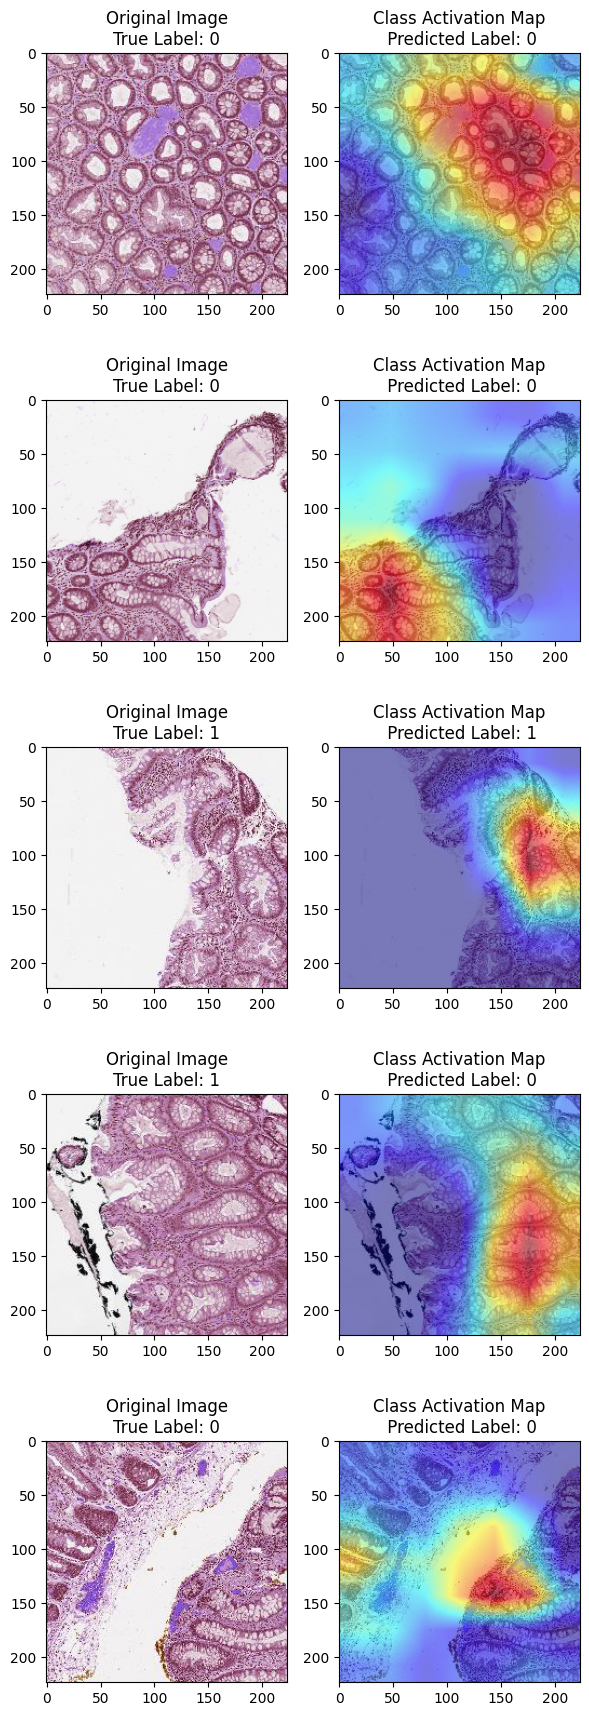

In [77]:
from eval import visualize_cam
num_samples = 5
visualize_cam(model, test_images, test_labels, num_samples)

In [40]:
torch.cuda.empty_cache()

# Train Vision Transformer

In [16]:
from train import train_vt
from transformers import ViTForImageClassification, ViTFeatureExtractor

epochs = 5
# We use a Pre-trained ViT model
model_name = "google/vit-base-patch16-224-in21k"
vit_model = ViTForImageClassification.from_pretrained(model_name)

optimizer = optim.Adam(vit_model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
train_vt(vit_model, train_loader, val_loader, criterion, optimizer, epochs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Loss: 0.5053, Train Accuracy: 0.7926, Val Accuracy: 0.7677
Epoch [2/5], Loss: 0.2908, Train Accuracy: 0.8955, Val Accuracy: 0.8260
Epoch [3/5], Loss: 0.1881, Train Accuracy: 0.9411, Val Accuracy: 0.8434
Epoch [4/5], Loss: 0.1334, Train Accuracy: 0.9595, Val Accuracy: 0.8280
Epoch [5/5], Loss: 0.0843, Train Accuracy: 0.9790, Val Accuracy: 0.8444


Accuracy: 0.8444216990788127
Precision: 0.8561643835616438
Recall: 0.6944444444444444
AUC: 0.9153790743742121


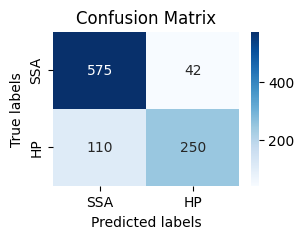

In [20]:
from eval import evaluate_vt_model,calculate_metrics

test_labels, test_probabilities, test_predictions = evaluate_vt_model(vit_model, test_loader, criterion, device)
auc = calculate_metrics(test_labels, test_probabilities, test_predictions)

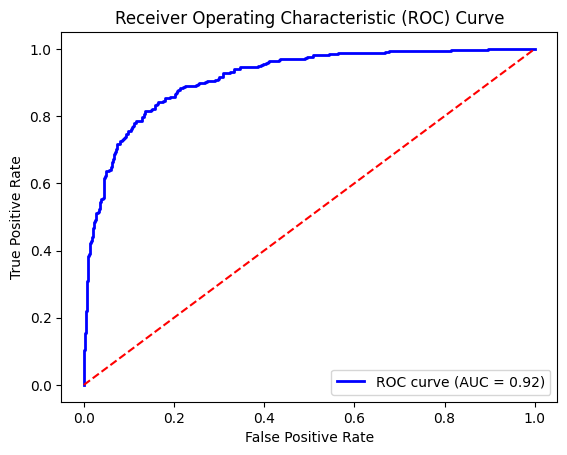

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test_labels, test_probabilities)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

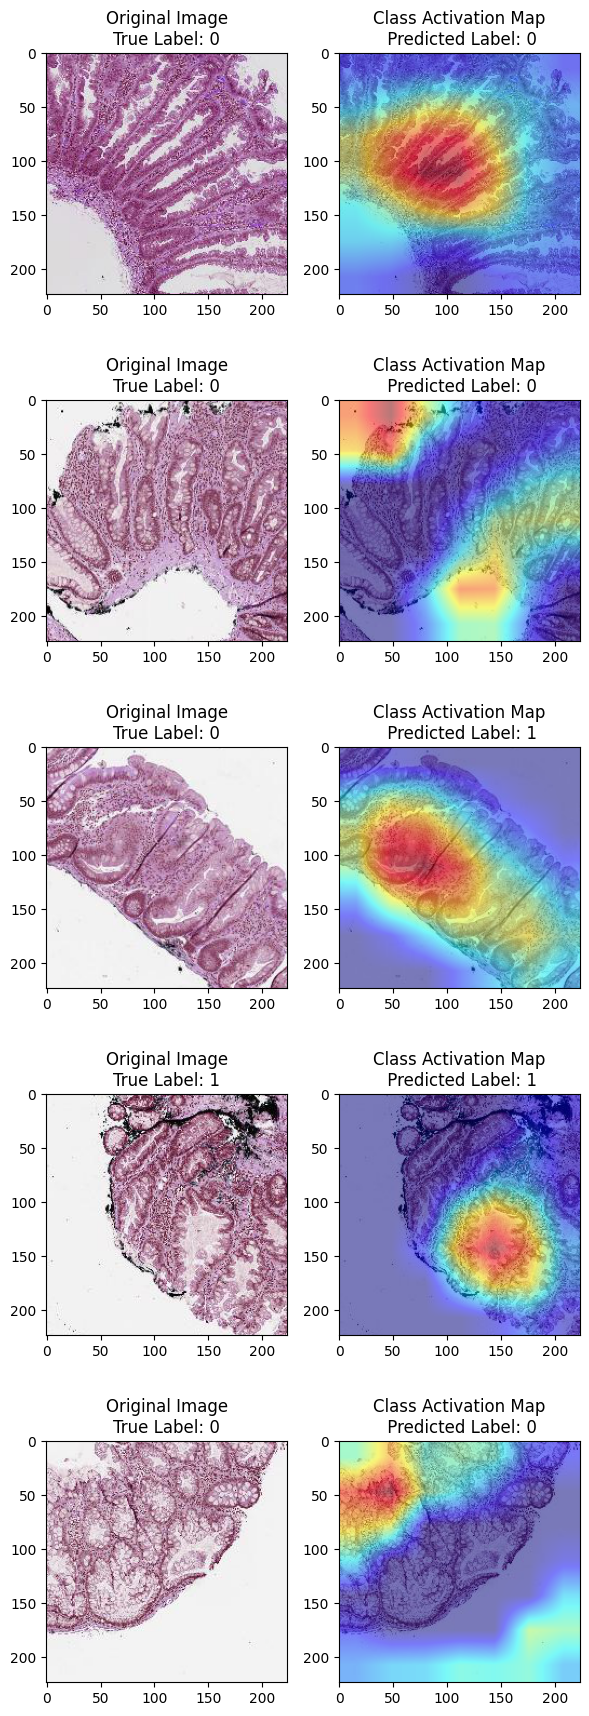

In [78]:
from eval import visualize_cam_vt
num_samples = 5
visualize_cam_vt(vit_model, test_images, test_labels, num_samples)